In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

## Question 1 :Exploratory Analysis

In [3]:
train = pd.read_csv("Data/PartA/20ng_train.csv", compression="bz2")
test = pd.read_csv("Data/PartA/20ng_test.csv", compression="bz2")
num2label = pd.read_csv("Data/PartA/20ng_labels.csv", compression="bz2")

In [4]:
print("The shape of train set is ", train.shape)
print("The shape of test set is ", test.shape)

The shape of train set is  (5648, 1001)
The shape of test set is  (1883, 1001)


In [5]:
print("The columns of data is:")
print(train.columns)

The columns of data is:
Index(['__', 'ability', 'able', 'ac', 'accept', 'access', 'according',
       'account', 'act', 'action',
       ...
       'worth', 'wouldn', 'write', 'written', 'wrong', 'wrote', 'year',
       'years', 'yes', 'class'],
      dtype='object', length=1001)


In [26]:
desc = test.describe()
for i in desc:
    if desc.loc["max", i]>1.0:
        print(i)

class


In [27]:
desc

,__,ability,able,ac,accept,access,according,account,act,action,...,worth,wouldn,write,written,wrong,wrote,year,years,yes,class
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,...,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,0.002292,0.002168,0.007335,0.002817,0.002701,0.004449,0.003012,0.001716,0.001886,0.001745,...,0.003018,0.005356,0.003746,0.003812,0.007960,0.001970,0.006214,0.008706,0.009449,3.345194
std,0.032391,0.021397,0.034312,0.032169,0.021777,0.032393,0.026133,0.022855,0.019504,0.018376,...,0.026231,0.033441,0.028779,0.032836,0.039182,0.020613,0.037389,0.041551,0.043570,2.208286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,0.864159,0.469412,0.337561,0.620254,0.310053,0.504324,0.420903,0.632166,0.336667,0.387412,...,0.490894,0.481298,0.434553,0.543384,0.470697,0.566179,0.537827,0.532047,0.590114,7.000000


In [25]:
test["class"].value_counts()

6    249
3    249
4    248
2    248
5    246
0    245
1    241
7    157
Name: class, dtype: int64

### ========== 1.1 ==========
From the columns in the train set, we can see that every feature is a word's term frequency value in a sample, so all the values of features will be in [0,1] and typical value will be 0. 
The train set has 5648 samples and 1001 columns. What's more, it has 1000 features and 1 label. As for label, there has 8 classes and 7 classes' number is about 740 while class 7 only have 471 samples. However, some samples only have a 1 without any values is not 0 which means the sample only have one word. That's strange.
### ========== 1.2 ==========
By loading the test set we can see that the test set has 1883 and 1001 columns. The test set has the same features as train set and test set's feature data ranges and distributions. As for label, there also has 8 classes and 7 classes' number is about 240 while class 7 only have 157 samples. This represents that the test set has the same distribution with train set and we can predict test set effectively by learning train set.
### ========== 1.3 ==========
When we just use the frequency of times a word appears in a document as a feature, there is a problem: some word like "is" will have a high frequency but they don't distinguish the document from others because other documents will have high values for these words too. So, we must decrease the influence of these words and take idf into account. If a word is common, it will appear in many documents thus has a low idf value. So the tf-idf value will be low too and it will not has big influence on our performance.

In [10]:
train_cols = train.columns[:-1]
train_X, train_y = train[train_cols], train["class"]
test_X, test_y = test[train_cols], test["class"]

## Question 2: Unsupervised Learning
### ========== 2.1 ==========
Because kMeans must choose k centroids, and different initialization of centroids will affect the performance. So it is highly dependent on the initialization of the centroids.  
As a result, the algorithm is often done several times with different initialization of the centroids. What's more, scikit-learn implement a k-means++ initial scheme to initialize the centroids to be (generally) distant from each other, leading to provably better results than random initialization.

### ========== 2.2 ==========
In my opinion, the number is 8. There are only 8 classes and choosing the number of clusters as 8 may cluster the data appropriately.

### ========== 2.3 ==========
1. MI can be expressed as $I(X;Y)=H(X)+H(Y)-H(X,Y)$, in which $H$ refer to entropy.  
2. Intuitively, mutual information measures the information that $X$ and $Y$ share: It measures how much knowing one of these variables reduces uncertainty about the other. So, it can measure similarity between two labels of the same data. 
3. Because MI is independent of the absolute values of the labels:  a permutation of the class or cluster label values won’t change the score value in any way, so it can be used to evaluate cluster result. However, MI have some shortcomings: MI's max value isn't 1, which is therefore harder to judge; when prediction get independent labels, the MI will reach the max value too. But we have 1883 test data and only 8 classes, so we won't get independent labels and can use MI to evaluate.

### ========== 2.4 ==========

In [42]:
ns = list(range(2,13))
amis = list()
for n in ns:
    print("n_clusters=%d"%n)
    kmeans = KMeans(n_clusters=n, n_init=50, random_state=1000)
    kmeans.fit(train_X)
    amis.append(adjusted_mutual_info_score(train_y, kmeans.labels_, average_method="max"))

n_clusters=2
n_clusters=3
n_clusters=4
n_clusters=5
n_clusters=6
n_clusters=7
n_clusters=8
n_clusters=9
n_clusters=10
n_clusters=11
n_clusters=12


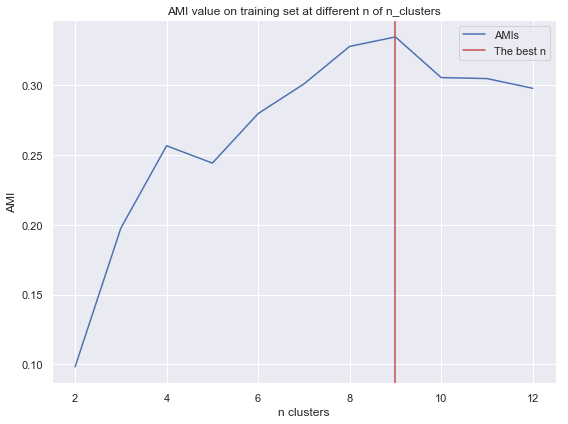

In [119]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ns, amis, label="AMIs")
ax.set(xlabel="n clusters",
       ylabel="AMI",
       title="AMI value on training set at different n of n_clusters")
max_idx = amis.index(max(amis))
ax.axvline(ns[max_idx], label="The best n", c="r")
ax.legend()
fig.tight_layout()
plt.savefig("Figure_7.jpg")
plt.show()

### ========== 2.5 ==========
We can see that: as the number of n_clusters increases, the AMI of cluster result increases too. However, when n_clusters = 9, the AMI get the highest value. Then, AMI begins to decrease.  
So, the result is very close to my expectation because my expectant number is 8. There only has a difference of 1.

### ========== 2.6 ==========

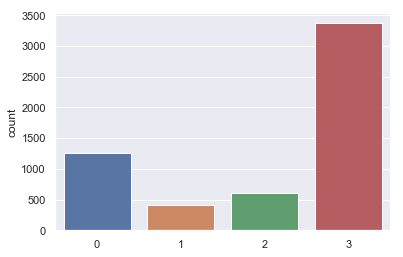

In [57]:
kmeans = KMeans(n_clusters=4, n_init=50, random_state=1000)
kmeans.fit(train_X)

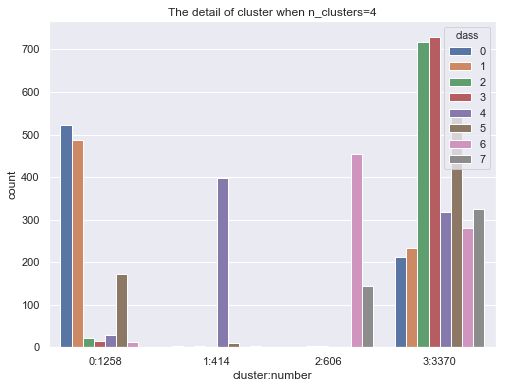

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x=kmeans.labels_, hue=train_y, ax=ax)
ticklabels = ["%d:%d"%(i,(kmeans.labels_==i).sum()) for i in range(4)]
ax.set_xticklabels(ticklabels)
ax.set_title("The detail of cluster when n_clusters=4")
ax.set_xlabel("cluster:number")
plt.savefig("Figure_8.jpg")
plt.show()

### ========== 2.6 ==========
From the image we can see that: When the n_clusters=4, the cluster result isn't good. \\   For cluster 0, 1258 data-points are assigned to it. In which, the major data-points is from class 0 and 1. And data-points from 5 have a significant proportion. \\  
For cluster 1 and 2, the cluster result is not bad. The major class of cluster 1 is class 4, and the major class of cluster 2 is class 6. \\  
However, for cluster 3, the result is very disappointing. It contains data-points from all the classes and all the classes' data-points have a significant proportion. \\  
So, the main problem is that the number of clusters is so small that KMeans algorithm can not find appropriate cluster for all the classes. Thus, increasing the number of n_clusters may get better performance. Obviously, it conform the observations in Question\ref{Q_UNSUP_LEARN}:\ref{Q_CLUSTER_TRENDS}.

## Question 3: Logistic Regression Classification
### ========== 3.1 ==========

In [75]:
for i in range(8):
    print("%d:%d"%(i,(train_y==i).sum()))

0:737
1:722
2:742
3:747
4:743
5:738
6:748
7:471


First give the expression of F1 score: $F1 = 2*\frac{P*R}{P+R}$, in which P is precision and R is recall. We can see that F1 score take both precision and recall into account. Only if precision and recall are high, F1 score can be a high value. So, using it is preferable to accuracy.   
As for macro-average method, it calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

### ========== 3.2 ==========
To define a baseline model, I choose a random guess machine. Because without any prior knowledge of the dataset, what we can do is just do random guess. And with random guess, then we can see how much better our model do comparing to the case that we don't learn anything from dataset. So, the base line is $f(x)=R(class)$, in which R means random choosing.

In [97]:
predict_y = [np.random.randint(0,8) for _ in test_y]

In [98]:
f1_score(y_true=test_y, y_pred=predict_y, average="macro")

0.12666425099208972

So, the F1 score of baseline on testing set is 0.127, which is a bad performance.

### ========== 3.3 ==========
As we all known, Logistic Regression is a binary classification method. To solve a muti-class class, SKlearn uses the one-vs-rest (OvR) scheme. For every class in the task, there will be a classifier to classify whether a sample belongs to this class. Then, combine all the results for every class we can get a final multi-class classification result.

### ========== 3.4 ==========

In [101]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [111]:
f1s = list()
for tr_idx, va_idx in skf.split(train_X, train_y):
    print("At %d fold."%len(f1s))
    tr_X, tr_y = train_X.iloc[tr_idx], train_y[tr_idx]
    va_X, va_y = train_X.iloc[va_idx], train_y[va_idx]
    lr = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0)
    lr.fit(tr_X, tr_y)
    pred = lr.predict(va_X)
    f1s.append(f1_score(va_y, pred, average="macro"))

At 0 fold.
At 1 fold.
At 2 fold.
At 3 fold.
At 4 fold.
At 5 fold.
At 6 fold.
At 7 fold.
At 8 fold.
At 9 fold.


In [113]:
f1s = np.array(f1s)
print("The average validation-set F1-score is %.3f."%f1s.mean())
print("The standard deviation of validation-set F1-score is %.3f."%f1s.std())

The average validation-set F1-score is 0.669.
The standard deviation of validation-set F1-score is 0.017.


The average validation-set F1-score is 0.669.
The standard deviation of validation-set F1-score is 0.017.
So, we can see that though Logistic Regression is a simple model, it can learn knowledge from dataset and do much better than random guess.

### ========== 3.5 ==========

In [133]:
c_vals = np.power(10, np.linspace(-4, 5, 19, endpoint=True))

In [148]:
f1_tr, f1_va = list(), list()
for c in c_vals:
    l1, l2 = list(), list()
    for tr_idx, va_idx in skf.split(train_X, train_y):
        print("At %d fold of c %.3e."%(len(l1), c))
        tr_X, tr_y = train_X.iloc[tr_idx], train_y[tr_idx]
        va_X, va_y = train_X.iloc[va_idx], train_y[va_idx]
        lr = LogisticRegression(solver="lbfgs", 
                                multi_class="multinomial", 
                                random_state=0, 
                                C=c)
        lr.fit(tr_X, tr_y)
        l1.append(f1_score(tr_y, lr.predict(tr_X), average="macro"))
        l2.append(f1_score(va_y, lr.predict(va_X), average="macro"))
    f1_tr.append(np.array(l1).mean())
    f1_va.append(np.array(l2).mean())

At 0 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 2 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 3 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 4 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 5 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 6 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 7 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 8 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 9 fold of c 1.000e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 2 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 3 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 4 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 5 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 6 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 7 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 8 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 9 fold of c 3.162e-04.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 1.000e-03.
At 2 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 3 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 4 fold of c 1.000e-03.
At 5 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 6 fold of c 1.000e-03.
At 7 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 8 fold of c 1.000e-03.
At 9 fold of c 1.000e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 3.162e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 3.162e-03.
At 2 fold of c 3.162e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 3 fold of c 3.162e-03.
At 4 fold of c 3.162e-03.
At 5 fold of c 3.162e-03.
At 6 fold of c 3.162e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefin

At 7 fold of c 3.162e-03.
At 8 fold of c 3.162e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 9 fold of c 3.162e-03.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 2 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 3 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 4 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 5 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 6 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 7 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 8 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 9 fold of c 1.000e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 1 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 2 fold of c 3.162e-02.
At 3 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 4 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 5 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 6 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 7 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 8 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 9 fold of c 3.162e-02.


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At 0 fold of c 1.000e-01.
At 1 fold of c 1.000e-01.
At 2 fold of c 1.000e-01.
At 3 fold of c 1.000e-01.
At 4 fold of c 1.000e-01.
At 5 fold of c 1.000e-01.
At 6 fold of c 1.000e-01.
At 7 fold of c 1.000e-01.
At 8 fold of c 1.000e-01.
At 9 fold of c 1.000e-01.
At 0 fold of c 3.162e-01.
At 1 fold of c 3.162e-01.
At 2 fold of c 3.162e-01.
At 3 fold of c 3.162e-01.
At 4 fold of c 3.162e-01.
At 5 fold of c 3.162e-01.
At 6 fold of c 3.162e-01.
At 7 fold of c 3.162e-01.
At 8 fold of c 3.162e-01.
At 9 fold of c 3.162e-01.
At 0 fold of c 1.000e+00.
At 1 fold of c 1.000e+00.
At 2 fold of c 1.000e+00.
At 3 fold of c 1.000e+00.
At 4 fold of c 1.000e+00.
At 5 fold of c 1.000e+00.
At 6 fold of c 1.000e+00.
At 7 fold of c 1.000e+00.
At 8 fold of c 1.000e+00.
At 9 fold of c 1.000e+00.
At 0 fold of c 3.162e+00.
At 1 fold of c 3.162e+00.
At 2 fold of c 3.162e+00.
At 3 fold of c 3.162e+00.
At 4 fold of c 3.162e+00.
At 5 fold of c 3.162e+00.
At 6 fold of c 3.162e+00.
At 7 fold of c 3.162e+00.
At 8 fold of

C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 1.000e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 3.162e+01.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 1.000e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 3.162e+02.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 1.000e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 3.162e+03.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 1.000e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 3.162e+04.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 0 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 1 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 2 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 3 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 4 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 5 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 6 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 7 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 8 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


At 9 fold of c 1.000e+05.


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


1.0
0.8169961852556071 0.6689909262264606


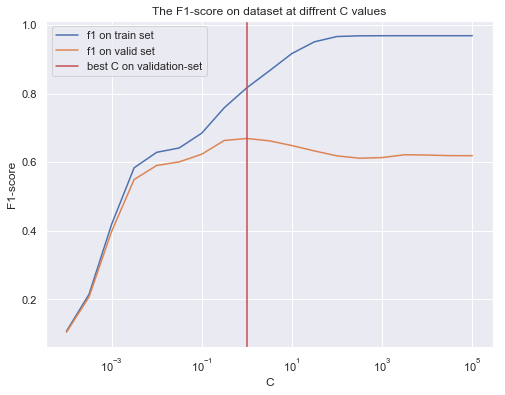

In [151]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale("log")
ax.plot(c_vals, f1_tr, label="f1 on train set")
ax.plot(c_vals, f1_va, label="f1 on valid set")
max_idx = f1_va.index(max(f1_va))
print(c_vals[max_idx])
print(f1_tr[max_idx], f1_va[max_idx])
ax.axvline(c_vals[max_idx], c="r", label="best C on validation-set")
ax.legend()
ax.set(xlabel="C", 
       ylabel="F1-score",
       title="The F1-score on dataset at diffrent C values")
plt.savefig("Figure_9.jpg")
plt.show()

### ========== 3.6 ==========
The optimal C value is 1 which is chose by performance on validation set. When C=1, the average F1-score on training set is 0.817, and it's 0.669 on validation set.  
Actually, the C is inverse of regularization strength. So, when C is small, the Logistic Model must be very simple and can not learn enough knowledge from dataset and perform bad on both two sets. Thus, increasing C make model do better. However, when C is too big that model can learn complicated function from training set which is not  appropriate for validation set. Thus, the model will do perfect on training set while performance on validation set will worse than it on training set.

### ========== 3.7 ==========

In [153]:
lr = LogisticRegression(solver="lbfgs", 
                        multi_class="multinomial", 
                        random_state=0,
                        C=1.0,
                        max_iter=200)
lr.fit(train_X, train_y)
preds = lr.predict(test_X)
sc = f1_score(test_y, preds, average="macro")
print("The F1-score on test-set of best model is %.3f"%sc)

The F1-score on test-set of best model is 0.675


The F1-score on test-set of best model is 0.675. And the best model's F1-score on validation set is 0.669. So, the F1-scores is very close which shows that the parameters we set make the model have a low variance and have strong generalization ability.